### GPU 사용

In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 만들어둔 model 불러오기

In [2]:
from model_cifar10 import SmallAlexNet as SAN

In [3]:
san = SAN().to(device)

In [4]:
from torchinfo import summary
summary(san, (64, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SmallAlexNet                             [64, 10]                  --
├─Sequential: 1-1                        [64, 128, 5, 5]           --
│    └─Conv2d: 2-1                       [64, 64, 26, 26]          9,472
│    └─ReLU: 2-2                         [64, 64, 26, 26]          --
│    └─LocalResponseNorm: 2-3            [64, 64, 26, 26]          --
│    └─Conv2d: 2-4                       [64, 192, 26, 26]         307,392
│    └─ReLU: 2-5                         [64, 192, 26, 26]         --
│    └─LocalResponseNorm: 2-6            [64, 192, 26, 26]         --
│    └─MaxPool2d: 2-7                    [64, 192, 12, 12]         --
│    └─Conv2d: 2-8                       [64, 256, 12, 12]         442,624
│    └─ReLU: 2-9                         [64, 256, 12, 12]         --
│    └─Conv2d: 2-10                      [64, 256, 12, 12]         590,080
│    └─ReLU: 2-11                        [64, 256, 12, 12]         

## CIFAR10 불러오기

In [5]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
batch_size = 128

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

In [10]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### 불러온 데이터 시각화

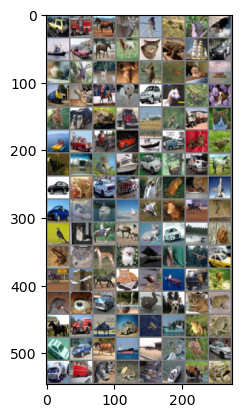

car   truck horse deer  bird  deer  frog  deer  ship  car   horse horse cat   frog  ship  car   bird  deer  deer  deer  deer  deer  dog   ship  truck deer  horse dog   car   horse frog  dog   dog   truck frog  truck plane bird  truck cat   ship  truck truck car   ship  truck cat   bird  plane truck bird  ship  car   deer  truck horse car   frog  car   truck bird  frog  cat   plane car   cat   ship  ship  plane horse horse bird  bird  cat   horse deer  cat   car   ship  frog  frog  cat   dog   cat   plane cat   plane car   horse plane horse cat   deer  ship  truck deer  cat   dog   car   bird  bird  dog   cat   frog  horse truck plane truck plane ship  frog  frog  car   car   horse ship  plane bird  deer  car   truck truck cat   frog  dog   ship  deer  frog 


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 학습하기

### loss 함수 & optimizer 정의

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(san.parameters(), lr=0.001)

In [13]:
epochs = 30

In [14]:
from tqdm import tqdm
accuracy_list = []
loss_list = []

n = len(trainloader) # 배치 개수

for epoch in range(epochs):
    running_loss = 0.0
    for data in tqdm(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = san(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    with torch.no_grad():
        total = 0
        correct = 0
        for data in testloader:
            images, labels = data
        
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = san(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted==labels).sum()
        
    avg_loss = running_loss/n
    accuracy = 100*correct/total
        
    loss_list.append(avg_loss)
    accuracy_list.append(accuracy.cpu().numpy())
    
    print("epoch : {}".format(epoch+1))
    print('loss : {:.6f}'.format(avg_loss))
    print("Accuracy : {:.2f}%".format(accuracy))

100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.35it/s]


epoch : 1
loss : 1.819096
Accuracy : 43.00%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.52it/s]


epoch : 2
loss : 1.393996
Accuracy : 53.50%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.53it/s]


epoch : 3
loss : 1.204178
Accuracy : 56.31%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.53it/s]


epoch : 4
loss : 1.089356
Accuracy : 61.78%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.52it/s]


epoch : 5
loss : 0.996349
Accuracy : 63.84%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.53it/s]


epoch : 6
loss : 0.928914
Accuracy : 64.89%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.49it/s]


epoch : 7
loss : 0.877548
Accuracy : 66.48%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.55it/s]


epoch : 8
loss : 0.823694
Accuracy : 67.45%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.58it/s]


epoch : 9
loss : 0.787110
Accuracy : 66.32%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.49it/s]


epoch : 10
loss : 0.755381
Accuracy : 69.44%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.44it/s]


epoch : 11
loss : 0.713699
Accuracy : 69.77%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.35it/s]


epoch : 12
loss : 0.694692
Accuracy : 69.83%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.47it/s]


epoch : 13
loss : 0.665017
Accuracy : 69.95%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.43it/s]


epoch : 14
loss : 0.630575
Accuracy : 71.21%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.51it/s]


epoch : 15
loss : 0.614082
Accuracy : 70.92%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.43it/s]


epoch : 16
loss : 0.591839
Accuracy : 71.88%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.49it/s]


epoch : 17
loss : 0.578037
Accuracy : 70.26%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.40it/s]


epoch : 18
loss : 0.556613
Accuracy : 71.32%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.58it/s]


epoch : 19
loss : 0.528589
Accuracy : 70.01%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.37it/s]


epoch : 20
loss : 0.520114
Accuracy : 70.88%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.56it/s]


epoch : 21
loss : 0.514029
Accuracy : 70.60%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.43it/s]


epoch : 22
loss : 0.492534
Accuracy : 71.55%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.53it/s]


epoch : 23
loss : 0.472328
Accuracy : 71.53%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.53it/s]


epoch : 24
loss : 0.458855
Accuracy : 72.16%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.54it/s]


epoch : 25
loss : 0.454843
Accuracy : 72.21%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.50it/s]


epoch : 26
loss : 0.438242
Accuracy : 71.44%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.45it/s]


epoch : 27
loss : 0.422191
Accuracy : 72.24%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.41it/s]


epoch : 28
loss : 0.416878
Accuracy : 71.47%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.53it/s]


epoch : 29
loss : 0.407564
Accuracy : 71.70%


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.49it/s]


epoch : 30
loss : 0.397683
Accuracy : 72.33%


### loss & accuracy 시각화

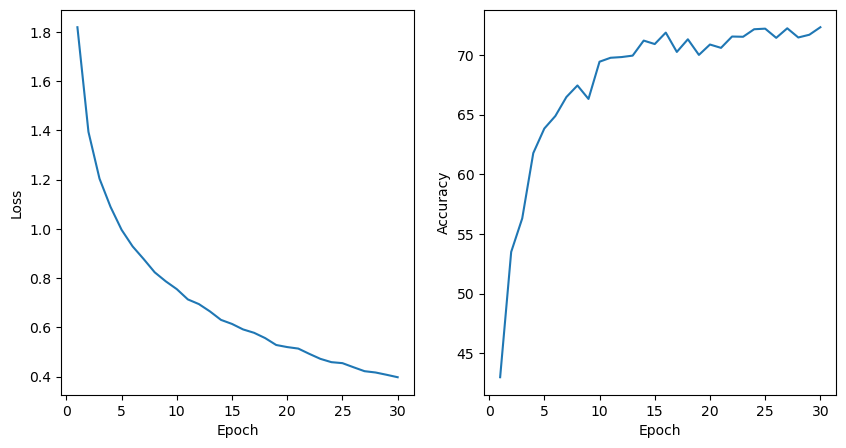

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(np.arange(1,epochs+1),loss_list)
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(np.arange(1,epochs+1), accuracy_list)
plt.show()

### model 저장

In [16]:
PATH = './cifar_alexnet.pth'
torch.save(san.state_dict(), PATH)

### model 불러오기

In [17]:
net = SAN().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
correct = 0
total = 0

with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 25.70it/s]

Accuracy of the network on the 10000 test images: 72 %


In [19]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.67it/s]

Accuracy for class: plane is 78.2 %
Accuracy for class: car   is 84.7 %
Accuracy for class: bird  is 53.1 %
Accuracy for class: cat   is 52.4 %
Accuracy for class: deer  is 68.4 %
Accuracy for class: dog   is 64.3 %
Accuracy for class: frog  is 83.8 %
Accuracy for class: horse is 77.1 %
Accuracy for class: ship  is 81.0 %
Accuracy for class: truck is 81.3 %
